In [1]:
import warnings
warnings.filterwarnings("ignore")  # Ignore all warnings
from typing import List, Dict, Any

import numpy as np
import matplotlib.pyplot as plt
from agentic_energy.language_models.basic_llm_amap import records_to_arrays, llm_solve, llm_solve_from_records, solve_daily_llm
from agentic_energy.data_loader import EnergyDataLoader, BatteryDataLoader
from agentic_energy.schemas import BatteryParams, DayInputs, EnergyDataRecord, SolveRequest, SolveFromRecordsRequest

2025-10-16 02:47:18.194 | DEBUG    | agentics.core.llm_connections:<module>:121 - AGENTICS is connecting to the following LLM API providers:
2025-10-16 02:47:18.194 | DEBUG    | agentics.core.llm_connections:<module>:129 - 0 - Gemini
2025-10-16 02:47:18.194 | DEBUG    | agentics.core.llm_connections:<module>:133 - 1 - OpenAI
2025-10-16 02:47:18.195 | DEBUG    | agentics.core.llm_connections:<module>:135 - Please add API keys in .env file to add or disconnect providers.
2025-10-16 02:47:18.204 | DEBUG    | agentics.core.llm_connections:get_llm_provider:29 - No LLM provider specified. Using the first available provider.
2025-10-16 02:47:18.205 | DEBUG    | agentics.core.llm_connections:get_llm_provider:31 - Available LLM providers: ['gemini', 'openai']. Using 'gemini'
2025-10-16 02:47:18.194 | DEBUG    | agentics.core.llm_connections:<module>:129 - 0 - Gemini
2025-10-16 02:47:18.194 | DEBUG    | agentics.core.llm_connections:<module>:133 - 1 - OpenAI
2025-10-16 02:47:18.195 | DEBUG    | 

Forecast Engine using device: cpu


#### Forecast Data Load

In [2]:
italy_forecast_obj = EnergyDataLoader(region = "ITALY", data_version="forecast", forecast_type="RF")
italy_forecast_data = italy_forecast_obj.load_region_data()
italy_forecast = await italy_forecast_obj.get_filtered_data("2018-01-01", "2018-01-01")

2025-10-16 02:47:19.372 | DEBUG    | agentics.core.agentics:from_csv:312 - Importing Agentics of type EnergyDataRecord from CSV /Users/millendroy/Projects/Agentic_Energy/Agentics_for_EnergyArbitrage_Battery/energy_arbitrage/agentic_energy/data/Italy_data_forecast_RF.csv


In [3]:
stats_forecast_consumption = await EnergyDataLoader.get_summary_stats_from_ag(italy_forecast_data, column="consumption")
print(stats_forecast_consumption.pretty_print())

Atype : <class 'agentic_energy.schemas.MetricStats'>
count: 24
min: 21.71582122
max: 34.94844843
avg: 27.93677364625
median: 28.378208385
p25: 24.5850403875
p75: 30.0580908925
std: 3.9238253542943533
var: 15.396405411003206




##### Actual Data Load

In [4]:
italy_actual_obj = EnergyDataLoader(region = "ITALY", data_version="actual")
italy_actual_data = italy_actual_obj.load_region_data()
italy_actual = await italy_actual_obj.get_filtered_data("2018-01-01", "2018-01-01")

2025-10-16 02:47:19.517 | DEBUG    | agentics.core.agentics:from_csv:312 - Importing Agentics of type EnergyDataRecord from CSV /Users/millendroy/Projects/Agentic_Energy/Agentics_for_EnergyArbitrage_Battery/energy_arbitrage/agentic_energy/data/Italy_data_actual.csv


In [5]:
stats_actual_consumption = await EnergyDataLoader.get_summary_stats_from_ag(italy_actual_data, column="consumption")
print(stats_actual_consumption.pretty_print())

Atype : <class 'agentic_energy.schemas.MetricStats'>
count: 24
min: 19.49
max: 30.97
avg: 24.374583333333334
median: 23.83
p25: 22.0275
p75: 25.564999999999998
std: 3.3568598659643545
var: 11.268508159722224




In [6]:
stats_forecast_consumption.states[0].p25

24.5850403875

#### Battery Config Load

In [7]:
batt = BatteryDataLoader(
    load_stats={
        "p25":stats_forecast_consumption.states[0].p25,
        "p75":stats_forecast_consumption.states[0].p75
    },
    duration_hours=4,
    soc_init=0.5,
    soc_min=0.0,
    soc_max=1.0,
    eta_c = 0.95,
    eta_d = 0.95,
    soc_target=0.5,
)
battery = batt.compute_battery_params()
print(batt.summary())

{'Capacity (kWh)': 21.89, 'Charge Power (kW)': 5.47, 'Discharge Power (kW)': 5.47, 'Efficiency (Charge/Discharge)': (0.95, 0.95), 'Duration (hours)': 4}


In [8]:
result_llm = []
day_info = []
decision_list = []
soc_list = []  # Initialize soc_list

for i in range(len(italy_forecast_data)//24):
    print(f"Solving day {i+1} of {len(italy_forecast_data)//24}")

    forecast_prices, forecast_demand = records_to_arrays(italy_forecast_data[i*24:(i+1)*24])
    actual_prices, actual_demand = records_to_arrays(italy_actual_data[i*24:(i+1)*24])
    day = DayInputs(
        prices_buy=actual_prices,
        demand_kw=actual_demand,
        prices_sell=actual_prices,
        allow_export=True,
        dt_hours=1.0,
        prices_buy_forecast=forecast_prices,
        demand_kw_forecast=forecast_demand,
        prices_sell_forecast=forecast_prices,
    )
    day_info.append(day)
    req = SolveRequest(
        battery=battery,
        day=day,
        solver=None,
        solver_opts=None
    )
    res = await solve_daily_llm(req)
    result_llm.append(res)
    decision_list += res.decision 
    battery.soc_init = res.soc[-1]
    soc_list += res.soc[:-1]

2025-10-16 02:47:20.584 | DEBUG    | agentics.core.agentics:__lshift__:518 - Executing task: 
        You are solving a daily battery scheduling optimization problem using forecast-based reasoning and constraint satisfaction.

        You are provided with both forecasted and actual market data:

        FORECAST INPUTS (for decision-making):
            - Forecasted buying prices: [47.31896137 41.78432284 37.49251592 36.728515   36.24872824 39.56044182
 43.50378076 51.54855095 55.71723352 51.20543591 51.3866384  55.1697128
 47.17853383 48.61988    49.63520408 51.79375316 59.66892529 61.94714286
 53.56690444 60.35956522 53.23160289 49.06159184 48.84639656 42.45350689]  (array of length T)
            - Forecasted selling prices: [47.31896137 41.78432284 37.49251592 36.728515   36.24872824 39.56044182
 43.50378076 51.54855095 55.71723352 51.20543591 51.3866384  55.1697128
 47.17853383 48.61988    49.63520408 51.79375316 59.66892529 61.94714286
 53.56690444 60.35956522 53.23160289 49.061

Solving day 1 of 1




╭──────────────────────────────────────────── Crew Execution Started ─────────────────────────────────────────────╮
│                                                                                                                 │
│  Crew Execution Started                                                                                         │
│  Name: crew                                                                                                     │
│  ID: c755360a-4d8b-4393-99bf-9bbb10958e5e                                                                       │
│  Tool Args:                                                                                                     │
│                                                                                                                 │
│                                                                                                                 │
╰─────────────────────────────────────────────────────────────────────────────────────────────────────────────────╯

╭─────────────────────────────────────────────── 🤖 Agent Started ────────────────────────────────────────────────╮
│                                                                                                                 │
│  Agent: Task Executor                                                                                           │
│                                                                                                                 │
│  Task:                                                                                                          │
│  Your task is to transduce a source Pydantic Object into the specified Output type. Generate only slots that    │
│  are logically deduced from the input information, otherwise live then null.                                    │
│                                                                                                                 │
│  Read carefully the following instructions for executing your task:                                             │
│                                                                                                                 │
│          You are solving a daily battery scheduling optimization problem using forecast-based reasoning and     │
│  constraint satisfaction.                                                                                       │
│                                                                                                                 │
│          You are provided with both forecasted and actual market data:                                          │
│                                                                                                                 │
│          FORECAST INPUTS (for decision-making):                                                                 │
│              - Forecasted buying prices: [47.31896137 41.78432284 37.49251592 36.728515   36.24872824           │
│  39.56044182                                                                                                    │
│   43.50378076 51.54855095 55.71723352 51.20543591 51.3866384  55.1697128                                        │
│   47.17853383 48.61988    49.63520408 51.79375316 59.66892529 61.94714286                                       │
│   53.56690444 60.35956522 53.23160289 49.06159184 48.84639656 42.45350689]  (array of length T)                 │
│              - Forecasted selling prices: [47.31896137 41.78432284 37.49251592 36.728515   36.24872824          │
│  39.56044182                                                                                                    │
│   43.50378076 51.54855095 55.71723352 51.20543591 51.3866384  55.1697128                                        │
│   47.17853383 48.61988    49.63520408 51.79375316 59.66892529 61.94714286                                       │
│   53.56690444 60.35956522 53.23160289 49.06159184 48.84639656 42.45350689]  (array of length T)                 │
│              - Forecasted demand: [24.95664627 23.92997141 22.42978245 21.71582122 21.87623452 22.6034125       │
│   24.622      25.58646667 27.94575438 30.17360503 29.74489392 32.93638194                                       │
│   29.62439343 27.9        27.81625    28.81066239 29.7110531  30.01958618                                       │
│   34.9371681  34.94844843 32.71125    31.79713258 29.21149144 24.47416155]  (array of length T)                 │
│                                                                                                                 │
│          ACTUAL INPUTS (for ex-post evaluation):                                                                │
│              - Realized buying prices: [45.82 44.16 42.24 39.29 36.   41.99 42.25 44.97 45.   44.94 45.02       │
│  45.71                                                                                                          │
│   46.7  43.98 44.96 47.53 49.91 54.3  51.91 51.38 49.2 

Output()

╭───────────────────────────────────────────── ✅ Agent Final Answer ─────────────────────────────────────────────╮
│                                                                                                                 │
│  Agent: Task Executor                                                                                           │
│                                                                                                                 │
│  Final Answer:                                                                                                  │
│  ```json                                                                                                        │
│  {                                                                                                              │
│    "status": "success",                                                                                         │
│    "message": "Battery scheduling optimization using forecast-based reasoning. The battery charges during low   │
│  forecasted price periods and discharges during high forecasted price periods to minimize realized cost, while  │
│  always meeting demand and respecting battery constraints.",                                                    │
│    "objective_cost": 10898.135083224872,                                                                        │
│    "charge_kw": [                                                                                               │
│      0.0,                                                                                                       │
│      5.47,                                                                                                      │
│      5.47,                                                                                                      │
│      5.47,                                                                                                      │
│      5.47,                                                                                                      │
│      5.47,                                                                                                      │
│      0.0,                                                                                                       │
│      0.0,                                                                                                       │
│      0.0,                                                                                                       │
│      0.0,                                                                                                       │
│      0.0,                                                                                                       │
│      0.0,                                                                                                       │
│      0.0,                                                                                                       │
│      0.0,                                                                                                       │
│      0.0,                                                                                                       │
│      0.0,                                                                                                       │
│      0.0,                                                                                                       │
│      0.0,                                                                                                       │
│      0.0,                                                                                                       │
│      0.0,                                                                                                       │
│      0.0,                                                                                                       │
│      0.0,                                              

╭──────────────────────────────────────────────── Task Completion ────────────────────────────────────────────────╮
│                                                                                                                 │
│  Task Completed                                                                                                 │
│  Name: 287a0816-4bac-4757-9a85-9827c7851210                                                                     │
│  Agent: Task Executor                                                                                           │
│  Tool Args:                                                                                                     │
│                                                                                                                 │
│                                                                                                                 │
╰─────────────────────────────────────────────────────────────────────────────────────────────────────────────────╯

╭──────────────────────────────────────────────── Crew Completion ────────────────────────────────────────────────╮
│                                                                                                                 │
│  Crew Execution Completed                                                                                       │
│  Name: crew                                                                                                     │
│  ID: c755360a-4d8b-4393-99bf-9bbb10958e5e                                                                       │
│  Tool Args:                                                                                                     │
│  Final Output: ```json                                                                                          │
│  {                                                                                                              │
│    "status": "success",                                                                                         │
│    "message": "Battery scheduling optimization using forecast-based reasoning. The battery charges during low   │
│  forecasted price periods and discharges during high forecasted price periods to minimize realized cost, while  │
│  always meeting demand and respecting battery constraints.",                                                    │
│    "objective_cost": 10898.135083224872,                                                                        │
│    "charge_kw": [                                                                                               │
│      0.0,                                                                                                       │
│      5.47,                                                                                                      │
│      5.47,                                                                                                      │
│      5.47,                                                                                                      │
│      5.47,                                                                                                      │
│      5.47,                                                                                                      │
│      0.0,                                                                                                       │
│      0.0,                                                                                                       │
│      0.0,                                                                                                       │
│      0.0,                                                                                                       │
│      0.0,                                                                                                       │
│      0.0,                                                                                                       │
│      0.0,                                                                                                       │
│      0.0,                                                                                                       │
│      0.0,                                                                                                       │
│      0.0,                                                                                                       │
│      0.0,                                                                                                       │
│      0.0,                                                                                                       │
│      0.0,                                                                                                       │
│      0.0,                                                                                                       │
│      0.0,                                             

2025-10-16 02:47:42.955 | DEBUG    | agentics.core.agentics:__lshift__:648 - Processed 1 states in 22.36880588531494 seconds
2025-10-16 02:47:42.956 | DEBUG    | agentics.core.agentics:__lshift__:700 - 1 states processed in 1.118440294265747 seconds average per state ...
2025-10-16 02:47:42.956 | DEBUG    | agentics.core.agentics:__lshift__:700 - 1 states processed in 1.118440294265747 seconds average per state ...



✓ Optimization successful
Atype : <class 'agentic_energy.schemas.SolveResponse'>
status: success
message: Battery scheduling optimization using forecast-based reasoning. The battery
  charges during low forecasted price periods and discharges during high forecasted
  price periods to minimize realized cost, while always meeting demand and respecting
  battery constraints.
objective_cost: 10898.135083224872
charge_kw:
- 0.0
- 5.47
- 5.47
- 5.47
- 5.47
- 5.47
- 0.0
- 0.0
- 0.0
- 0.0
- 0.0
- 0.0
- 0.0
- 0.0
- 0.0
- 0.0
- 0.0
- 0.0
- 0.0
- 0.0
- 0.0
- 0.0
- 0.0
- 5.47
discharge_kw:
- 0.0
- 0.0
- 0.0
- 0.0
- 0.0
- 0.0
- 0.0
- 0.0
- 0.0
- 0.0
- 0.0
- 0.0
- 0.0
- 0.0
- 0.0
- 0.0
- 0.0
- 0.0
- 0.0
- 0.0
- 0.0
- 0.0
- 0.0
- 0.0
import_kw:
- 22.98
- 16.3425
- 15.29
- 14.5
- 14.02
- 14.37
- 21.1
- 22.1
- 22.4
- 23.59
- 24.37
- 24.96
- 25.06
- 23.9
- 23.49
- 23.76
- 25.24
- 29.1
- 30.35
- 30.97
- 30.34
- 28.82
- 26.54
- 18.58
export_kw:
- 0.0
- 0.0
- 0.0
- 0.0
- 0.0
- 0.0
- 0.0
- 0.0
- 0.0
- 0.0


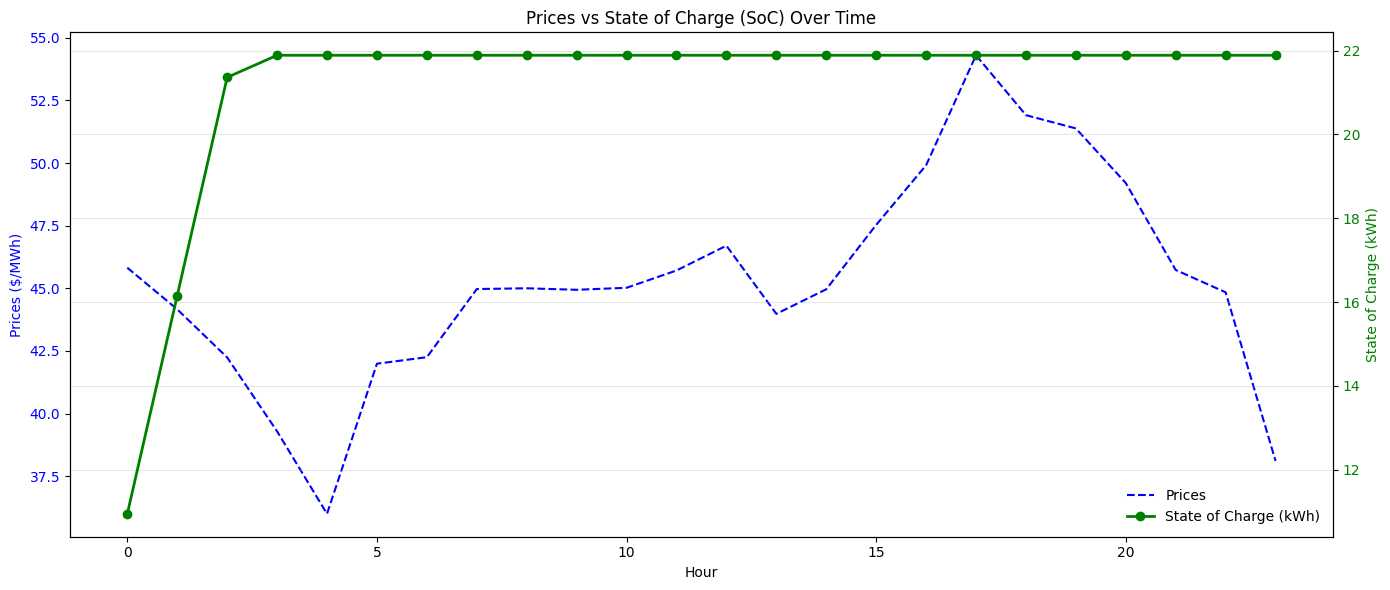

In [9]:
import numpy as np
import matplotlib.pyplot as plt

hours = np.arange(24)
fig, ax1 = plt.subplots(figsize=(14, 6))

# --- Primary axis (Prices) ---
ax1.plot(hours, day_info[0].prices_buy, '--b', label='Prices')
ax1.set_xlabel('Hour')
ax1.set_ylabel('Prices ($/MWh)', color='b')
ax1.tick_params(axis='y', labelcolor='b')

# --- Secondary axis (State of Charge) ---
ax2 = ax1.twinx()
ax2.plot(hours, np.array(result_llm[0].soc[1:]) * battery.capacity_kwh,
         '-og', label='State of Charge (kWh)', linewidth=2, markersize=6)
ax2.set_ylabel('State of Charge (kWh)', color='g')
ax2.tick_params(axis='y', labelcolor='g')


# --- Legends ---
lines_1, labels_1 = ax1.get_legend_handles_labels()
lines_2, labels_2 = ax2.get_legend_handles_labels()
ax2.legend(lines_1 + lines_2, labels_1 + labels_2, loc='best', frameon=False)

plt.title('Prices vs State of Charge (SoC) Over Time')
plt.grid(alpha=0.3)
plt.tight_layout()
plt.show()


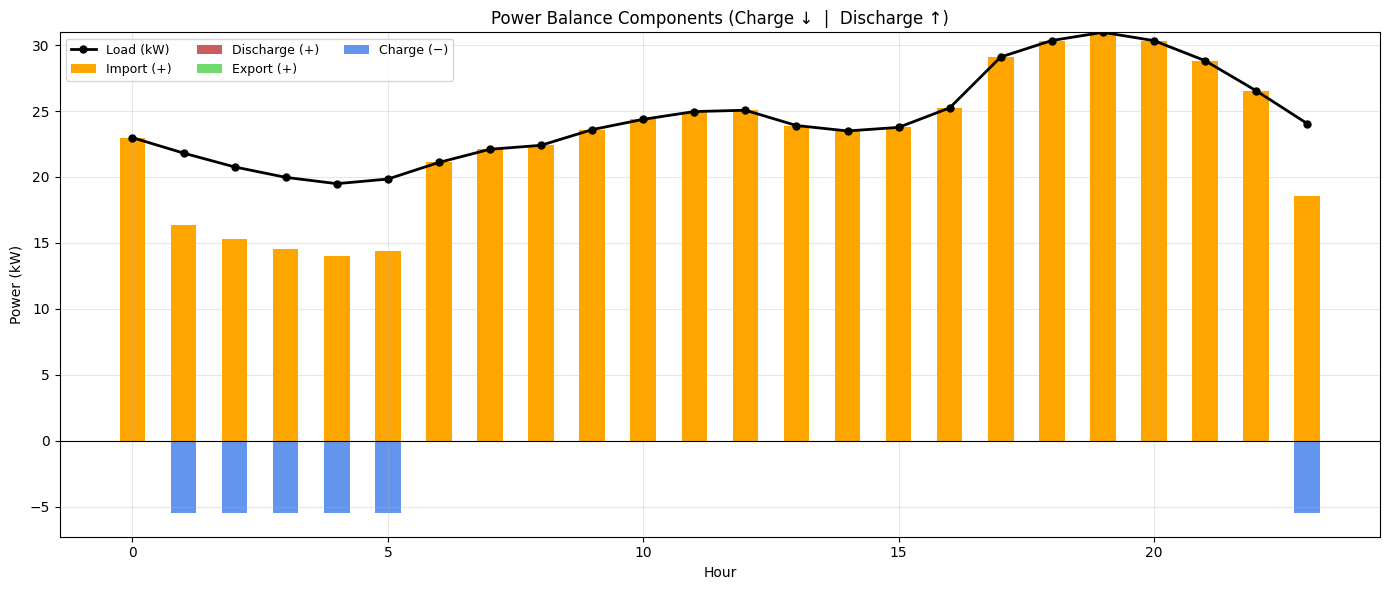

In [10]:
import numpy as np
import matplotlib.pyplot as plt

hours = np.arange(24)

# Data arrays
load = np.array(day_info[0].demand_kw)
charge = np.array(result_llm[0].charge_kw)
discharge = np.array(result_llm[0].discharge_kw)
import_kw = np.array(result_llm[0].import_kw)
export_kw = np.array(result_llm[0].export_kw) if getattr(day_info[0], "allow_export", False) else np.zeros_like(load)

# Flip battery convention for visualization
charge_vis = -charge       # show charge below 0
discharge_vis = discharge  # show discharge above 0

# ---------------------- PLOT ----------------------
fig, ax = plt.subplots(figsize=(14, 6))

# --- positive side stacking (Import + Discharge + Export) ---
# import is base layer
ax.bar(hours, import_kw, width=0.5, color='orange', label='Import (+)')
# discharge stacked on top of import
ax.bar(hours, discharge_vis, width=0.5, bottom=import_kw, color='indianred', label='Discharge (+)')
# export stacked on top (for clear separation)
ax.bar(hours, export_kw, width=0.5, bottom=import_kw + discharge_vis, color='limegreen', alpha=0.7, label='Export (+)')

# --- negative side stacking (Charge only) ---
ax.bar(hours, charge_vis, width=0.5, color='cornflowerblue', label='Charge (−)')

# --- Load as line ---
ax.plot(hours, load, '-ok', linewidth=2, markersize=5, label='Load (kW)')

# Formatting
ax.axhline(0, color='black', linewidth=0.8)
ax.set_ylabel("Power (kW)")
ax.set_xlabel("Hour")
ax.set_title("Power Balance Components (Charge ↓  |  Discharge ↑)")
ax.legend(ncol=3, loc='upper left', fontsize=9)
ax.grid(alpha=0.3)

plt.tight_layout()
plt.show()


In [11]:
total_objective_value = 0
for day_result in result_llm:
    total_objective_value += day_result.objective_cost
print(f"Total Objective Value over all days: ${total_objective_value:.2f} for {len(result_llm)} days")

Total Objective Value over all days: $10898.14 for 1 days


# Checking LLM Connection

In [5]:
# Reload environment variables and test with GPT-3.5-turbo
import os
from dotenv import load_dotenv
load_dotenv()  # Reload environment variables from .env file

# Test the LLM connection
from agentics.core.llm_connections import get_llm_provider
try:
    llm = get_llm_provider("gemini")
    response = llm.call("Hello! Can you briefly introduce yourself?")
    print("✅ LLM Connection Successful!")
    print(f"Response: {response}")
except Exception as e:
    print(f"❌ LLM Connection Failed: {e}")
    print("\nTroubleshooting options:")
    print("1. Check if your OpenAI API key is valid")
    print("2. Ensure you have sufficient OpenAI credits")
    print("3. Try using gpt-3.5-turbo instead of gpt-4")
    print("4. Consider using Gemini as an alternative")

2025-10-16 03:12:44.880 | DEBUG    | agentics.core.llm_connections:get_llm_provider:42 - Using specified LLM provider: gemini


✅ LLM Connection Successful!
Response: Hi there! I'm a large language model, trained by Google. I'm designed to be informative and comprehensive. I can generate different kinds of creative text formats, like poems, code, scripts, musical pieces, email, letters, etc. I will try my best to fulfill all your requirements. I'm still under development, but I'm always learning new things. How can I help you today?

